In [101]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [102]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [103]:
NUM_CLASSES = 12

# Dataset reading

In [104]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [105]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [107]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [108]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,202 (4.70 KB)

 Trainable params: 1,202 (4.70 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [110]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True  # Helps debug by disabling graph mode
)

# Model training

In [111]:
try:
    history = model.fit(
        X_train.astype(np.float32),
        y_train,
        epochs=10,  # Start with fewer epochs
        batch_size=32,  # Reduced from 128
        validation_data=(X_test.astype(np.float32), y_test),
        callbacks=[cp_callback, es_callback],
        verbose=1
    )
except Exception as e:
    print("Detailed error:", str(e))
    raise

Epoch 1/10
327/328 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1917 - loss: 2.3606
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.1922 - loss: 2.3595 - val_accuracy: 0.4291 - val_loss: 1.7253
Epoch 2/10
327/328 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4056 - loss: 1.7690
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4057 - loss: 1.7686 - val_accuracy: 0.5612 - val_loss: 1.3018
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4776 - loss: 1.5089
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.4777 - loss: 1.5088 - val_accuracy: 0.6699 - val_loss: 1.0810
Epoch 4/10
327/328 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5072 - loss: 1.3970
Epoch 4: saving model to model/keypoint_classifier/keypoint_clas

In [112]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7635 - loss: 0.7749


In [113]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [114]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[1.3471650e-01 5.5390157e-02 6.2979781e-03 1.3290782e-01 2.6278036e-02
 4.2000543e-02 3.1419143e-01 1.7620600e-06 9.5516632e-05 2.8811994e-01
 3.8031825e-08 3.0587671e-07]
6


# Confusion matrix

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


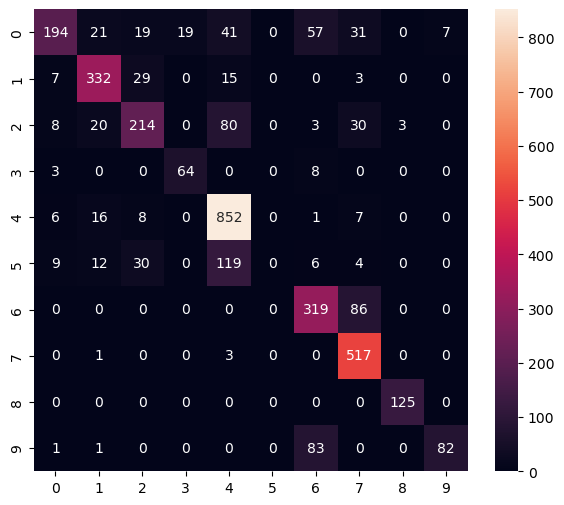

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.50      0.63       389
           1       0.82      0.86      0.84       386
           2       0.71      0.60      0.65       358
           3       0.77      0.85      0.81        75
           4       0.77      0.96      0.85       890
           5       0.00      0.00      0.00       180
           6       0.67      0.79      0.72       405
           7       0.76      0.99      0.86       521
           8       0.98      1.00      0.99       125
           9       0.92      0.49      0.64       167

    accuracy                           0.77      3496
   macro avg       0.73      0.70      0.70      3496
weighted avg       0.74      0.77      0.74      3496



C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [116]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [117]:
try:
    # Create a concrete function for conversion
    run_model = tf.function(lambda x: model(x))
    concrete_func = run_model.get_concrete_function(
        tf.TensorSpec([1, *X_train.shape[1:]], dtype=tf.float32))
    
    # Convert the model
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_quantized_model = converter.convert()
    
    # Save the quantized model
    with open(tflite_save_path, 'wb') as f:
        f.write(tflite_quantized_model)
    print("TFLite conversion successful!")
    
except Exception as e:
    print(f"Conversion failed: {str(e)}")
    # Fallback to SavedModel approach if needed
    try:
        model.save('temp_savedmodel', save_format='tf')
        converter = tf.lite.TFLiteConverter.from_saved_model('temp_savedmodel')
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_quantized_model = converter.convert()
        with open(tflite_save_path, 'wb') as f:
            f.write(tflite_quantized_model)
        print("Used SavedModel fallback successfully!")
    except Exception as e2:
        print(f"Fallback also failed: {str(e2)}")
        raise

TFLite conversion successful!


# Inference test

In [118]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [119]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Prepare test input (ensure correct shape and dtype)
test_input = np.array([X_test[0]], dtype=np.float32)
if test_input.shape[1] != input_details[0]['shape'][1]:
    test_input = test_input.reshape(input_details[0]['shape'])

In [120]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [121]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [122]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.3471651e-01 5.5390187e-02 6.2979832e-03 1.3290787e-01 2.6278064e-02
 4.2000581e-02 3.1419131e-01 1.7620594e-06 9.5516596e-05 2.8811997e-01
 3.8031882e-08 3.0587657e-07]
6
